In [1]:
%matplotlib inline

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

import climlab

### Some constants (GHG concentrations, albedo, and depth)

In [2]:
# Greenouse gas concentrations:
CO2_ref=280E-6 # parts per million
CO2_2=2*CO2_ref
CO2_4=4*CO2_ref
CO2_half = CO2_ref/2

# other greenhouse gas concentrations
CH4=700E-9 # ppbv
N2O=280E-9 # ppbv

# surface model
ALB=0.3 # represents global planetary albedo (not ocean albedo!)
DEPTH=2.5 # slap ocean depth

nexp = 4 #number of experiments

### Get monthly surface temperatures from NCEP-NCAR Reanalysis Dataset

In [3]:
actual_temp = xr.open_dataset("skt.sfc.mon.ltm.1991-2020.nc")

/knight/anaconda_aug22/envs/aug22_env/lib/python3.10/site-packages/xarray/coding/times.py:682: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/knight/anaconda_aug22/envs/aug22_env/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [4]:
#get index of closest coordinates
temp_lat_ind = np.argmin(np.abs(40.730610 - actual_temp['lat'].values))
temp_lon_ind = np.argmin(np.abs(286.064758 - actual_temp['lon'].values))

#get closest coordinates in NCEP-NCAR dataset
temp_latitude = (actual_temp['lat'].values)[temp_lat_ind]
temp_longitude = (actual_temp['lon'].values)[temp_lon_ind]

#get actual surface temp from NCEP-NCAR
actual_temp = actual_temp.isel(lon=temp_lon_ind,lat=temp_lat_ind)

In [5]:
#convert temperatures into Kelvin
obs_temp = actual_temp.skt.values+273.15

In [60]:
temp_latitude,temp_longitude

(40.9517, 286.875)

## Get monthly solar insolation from CERES Data

In [6]:
solar_influx = xr.open_dataset("CERES_EBAF-TOA_Ed4.1_Subset_200101-202112.nc")

In [7]:
#get index of closest coordinates
sol_lat_ind = np.argmin(np.abs(40.730610 - solar_influx['lat'].values))
sol_lon_ind = np.argmin(np.abs(286.064758 - solar_influx['lon'].values))

#get closest coordinates in CERES dataset
sol_latitude = (solar_influx['lat'].values)[sol_lat_ind]
sol_longitude = (solar_influx['lon'].values)[sol_lon_ind]

#get actual solar insolation from CERES
solar_influx = solar_influx.isel(lon=sol_lon_ind,lat=sol_lat_ind)

In [61]:
sol_latitude,sol_longitude

(40.5, 286.5)

## Get monthly mean specific humidity for the 26 pressure levels

In [8]:
# Get the water vapor data from CESM output
cesm_data_path = "http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/"

# Overall dataset for specific humidity
atm_control = xr.open_dataset(cesm_data_path + "cpl_1850_f19/concatenated/cpl_1850_f19.cam.h0.nc")

In [9]:
#get index of closest coordinates
lat_ind = np.argmin(np.abs(40.730610 - atm_control['lat'].values))
lon_ind = np.argmin(np.abs(286.064758 - atm_control['lon'].values))

#get closest coordinates in CESM dataset
latitude = (atm_control['lat'].values)[lat_ind]
longitude = (atm_control['lon'].values)[lon_ind]

#get specific humidity from CESM
atm_control = atm_control.isel(lon=lon_ind,lat=lat_ind)

In [62]:
latitude,longitude

(40.73684210526315, 285.0)

## Get mean monthly specific humidity and solar insolation

In [10]:
#declare arrays containing monthly specific humidity and solar insolation
master_Qmon = np.zeros((12,26))
master_solmon = np.zeros(12)

for i in range(12):
    atm_mon = atm_control.sel(time=(atm_control['time.month'] == i+1))
    sol_mon = solar_influx.sel(time=(solar_influx['time.month'] == i+1))
    
    # Take NYC monthly average of the specific humidity and solar insolation
    Qmon = (atm_mon.Q).mean(dim=('time'))
    SolMon = (sol_mon.solar_mon).mean(dim=('time'))
    
    # Append into master array the monthly Q values per pressure level
    master_Qmon[i] = Qmon.values
    master_solmon[i] = SolMon.values

#  Create the single-column model domain
levels=Qmon.lev #xarray structure contains level (pressure levels)

### Adding the convective adjustment to the model and performing for three experiments

In [11]:
Ts_equil = np.zeros((12,nexp)) 
OLR_equil = np.zeros((12,nexp)) 
ASR_equil = np.zeros((12,nexp))

for j in range(12):
    ####### Reference Experiment ###############
    #  Make a model on same vertical domain as the GCM
    mystate_ref = climlab.column_state(lev=levels, water_depth=DEPTH)
    #  Create the model itself -- radiation only!
    rad_ref = climlab.radiation.RRTMG(name='Radiation (all gases)',  # give our model a name!
                                  state=mystate_ref,   # give our model an initial condition!
                                  specific_humidity=master_Qmon[j],  # tell the model how much water vapor there is
                                  albedo = ALB,  # this the SURFACE shortwave albedo
                                  timestep = climlab.constants.seconds_per_day,  # set the timestep to one day (measured in seconds)
                                  lat = latitude, lon = longitude,
                                  insolation = np.array([master_solmon[j]])  
                                 )
    rad_ref.absorber_vmr['CO2'] = CO2_ref
    # other greenhouse gas concentrations
    rad_ref.absorber_vmr['CH4'] = CH4
    rad_ref.absorber_vmr['N2O'] = N2O
    rad_ref.name = 'reference run'
    #  Now create the convection model
    conv_ref = climlab.convection.ConvectiveAdjustment(name='Convection',
                                                   state=mystate_ref,
                                                   adj_lapse_rate=6.5, # this is the key parameter! We'll discuss below
                                                   timestep=rad_ref.timestep,  # same timestep!
                                                   lat = latitude, lon = longitude,
                                                   insolation = np.array([master_solmon[j]])
                                                      )
    #  Here is where we build the model by coupling together the two components
    rcm_ref = climlab.couple([rad_ref, conv_ref], name='RCM_ref')
    # one first time step integration forward
    # rad_ref.step_forward() # do one model integration step forward
    
    rcm_ref.step_forward() # do one model integration step forward
    ############################################################

    ####### Experiment 1: Double CO2 ###############
    #  Make a model on same vertical domain as the GCM
    mystate_2 = climlab.column_state(lev=levels, water_depth=DEPTH)
    #  Create the model itself -- radiation only!
    rad_exp_2 = climlab.radiation.RRTMG(name='Radiation (all gases)',  # give our model a name!
                                  state=mystate_2,   # give our model an initial condition!
                                  specific_humidity=master_Qmon[j],  # tell the model how much water vapor there is
                                  albedo = ALB,  # this the SURFACE shortwave albedo
                                  timestep = climlab.constants.seconds_per_day,  # set the timestep to one day (measured in seconds)
                                  lat = latitude, lon = longitude,
                                  insolation = np.array([master_solmon[j]])
                                       )
    
    rad_exp_2.absorber_vmr['CO2'] = CO2_2
    # other greenhouse gas concentrations
    rad_exp_2.absorber_vmr['CH4'] = CH4
    rad_exp_2.absorber_vmr['N2O'] = N2O
    rad_exp_2.name = '2xCO2'
    #  Now create the convection model
    conv_exp2 = climlab.convection.ConvectiveAdjustment(name='Convection',
                                                   state=mystate_2,
                                                   adj_lapse_rate=6.5, # this is the key parameter! We'll discuss below
                                                   timestep=rad_exp_2.timestep,  # same timestep!
                                                   lat = latitude, lon = longitude,
                                                    insolation = np.array([master_solmon[j]])
                                                       )
    #  Here is where we build the model by coupling together the two components
    rcm_2 = climlab.couple([rad_exp_2, conv_exp2], name='RCM_2')
    # one first time step integration forward
    # rad_exp_2.step_forward() # do one model integration step forward
    
    rcm_2.step_forward() # do one model integration step forward
    ############################################################
    
    ####### Experiment 2: Quadruple CO2 ###############
    #  Make a model on same vertical domain as the GCM
    mystate_4 = climlab.column_state(lev=levels, water_depth=DEPTH)
    #  Create the model itself -- radiation only!
    rad_exp_4 = climlab.radiation.RRTMG(name='Radiation (all gases)',  # give our model a name!
                                  state=mystate_4,   # give our model an initial condition!
                                  specific_humidity=master_Qmon[j],  # tell the model how much water vapor there is
                                  albedo = ALB,  # this the SURFACE shortwave albedo
                                  timestep = climlab.constants.seconds_per_day,  # set the timestep to one day (measured in seconds)
                                  lat = latitude, lon = longitude,
                                        insolation = np.array([master_solmon[j]])
                                       )
    rad_exp_4.absorber_vmr['CO2'] = CO2_4
    # other greenhouse gas concentrations
    rad_exp_4.absorber_vmr['CH4'] = CH4
    rad_exp_4.absorber_vmr['N2O'] = N2O
    rad_exp_4.name = '4xCO2'
    #  Now create the convection model
    conv_exp4 = climlab.convection.ConvectiveAdjustment(name='Convection',
                                                   state=mystate_4,
                                                   adj_lapse_rate=6.5, # this is the key parameter! We'll discuss below
                                                   timestep=rad_exp_4.timestep,  # same timestep!
                                                   lat = latitude, lon = longitude,
                                                    insolation = np.array([master_solmon[j]])
                                                       )
    #  Here is where we build the model by coupling together the two components
    rcm_4 = climlab.couple([rad_exp_4, conv_exp4], name='RCM_4')
    # one first time step integration forward
    # rad_exp_4.step_forward() # do one model integration step forward
    
    rcm_4.step_forward() # do one model integration step forward
    ############################################################
    
    ####### Experiment 3: Half CO2 ###############
    #  Make a model on same vertical domain as the GCM
    mystate_half = climlab.column_state(lev=levels, water_depth=DEPTH)
    #  Create the model itself -- radiation only!
    rad_exp_half = climlab.radiation.RRTMG(name='Radiation (all gases)',  # give our model a name!
                                  state=mystate_half,   # give our model an initial condition!
                                  specific_humidity=master_Qmon[j],  # tell the model how much water vapor there is
                                  albedo = ALB,  # this the SURFACE shortwave albedo
                                  timestep = climlab.constants.seconds_per_day,  # set the timestep to one day (measured in seconds)
                                  lat = latitude, lon = longitude,
                                        insolation = np.array([master_solmon[j]])
                                       )
    rad_exp_half.absorber_vmr['CO2'] = CO2_half
    # other greenhouse gas concentrations
    rad_exp_half.absorber_vmr['CH4'] = CH4
    rad_exp_half.absorber_vmr['N2O'] = N2O
    rad_exp_half.name = 'half CO2'
    #  Now create the convection model
    conv_exp_half = climlab.convection.ConvectiveAdjustment(name='Convection',
                                                   state=mystate_half,
                                                   adj_lapse_rate=6.5, # this is the key parameter! We'll discuss below
                                                   timestep=rad_exp_half.timestep,  # same timestep!
                                                   lat = latitude, lon = longitude,
                                                    insolation = np.array([master_solmon[j]])
                                                       )
    #  Here is where we build the model by coupling together the two components
    rcm_half = climlab.couple([rad_exp_half, conv_exp_half], name='RCM_half')
    #one first time step integration forward
    # rad_exp_half.step_forward() # do one model integration step forward
    
    rcm_half.step_forward() # do one model integration step forward
    ############################################################
    
    # rcm_models = [rad_ref, rad_exp_2, rad_exp_4, rad_exp_half]
    
    rcm_models = [rcm_ref, rcm_2, rcm_4, rcm_half]
    
    ####### Integrate the model over one year ###############
    # number of years in simulation
    nyears=1

    # number of time steps (n=years* days in year , calculated)
    nsteps=int(365*nyears)
    time=np.zeros(nsteps)
    output_Ts=np.zeros(shape=[nsteps,nexp])
    output_OLR=np.zeros(shape=[nsteps,nexp])
    output_ASR=np.zeros(shape=[nsteps,nexp])

    print("calculate ... ")
    for t in range(nsteps):
        for i,model in enumerate(rcm_models):
            model.step_forward()
            time[t]=t
            # store transient model diagnostice
            output_Ts[t,i]= model.Ts[0] # surface temperature (as float number)
            output_OLR[t,i]= model.diagnostics['OLR'][0] 
            output_ASR[t,i]= model.diagnostics['ASR'][0]# extract the float point numbers
    print(f"Done integrating models over {t} time steps")
    ############################################################

    ####### Get final Ts, OLR, and ASR after 365 time steps ###############
    Ts_equil[j] = output_Ts[-1,:]
    OLR_equil[j] = output_OLR[-1,:]
    ASR_equil[j] = output_ASR[-1,:]
    ############################################################

calculate ... 
Done integrating models over 364 time steps
calculate ... 
Done integrating models over 364 time steps
calculate ... 
Done integrating models over 364 time steps
calculate ... 
Done integrating models over 364 time steps
calculate ... 
Done integrating models over 364 time steps
calculate ... 
Done integrating models over 364 time steps
calculate ... 
Done integrating models over 364 time steps
calculate ... 
Done integrating models over 364 time steps
calculate ... 
Done integrating models over 364 time steps
calculate ... 
Done integrating models over 364 time steps
calculate ... 
Done integrating models over 364 time steps
calculate ... 
Done integrating models over 364 time steps


## Plot model's monthly temperature profile for NYC

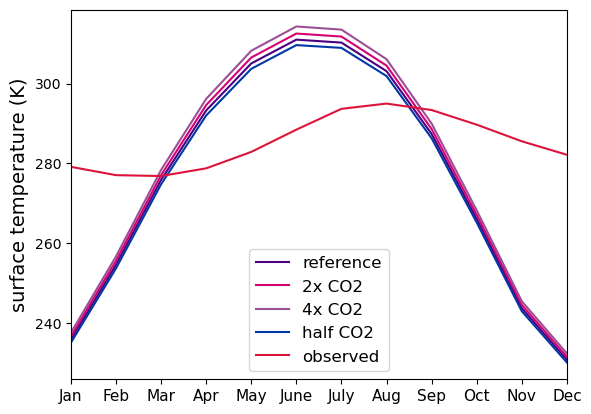

In [12]:
colors = ["#4b0082","#D60270","#9B4F96","#0038A8"]
months = ["Jan","Feb","Mar","Apr","May", "June","July","Aug","Sep","Oct","Nov","Dec"]
exp_label = ["reference","2x CO2", "4x CO2", "half CO2"]
for l in range(nexp):
    plt.plot(Ts_equil[:,l],color=colors[l],label=exp_label[l])

plt.plot(obs_temp,color="crimson",label="observed")

plt.xlim(0,11)
plt.xticks(np.arange(12),months,fontsize=11)
plt.ylabel("surface temperature (K)",fontsize=14)
plt.legend(loc="best",fontsize=12)

# plt.savefig("temperature figures/nyc_temp.png",dpi=300,bbox_inches="tight")
plt.show()

## Plotting difference between temperatures

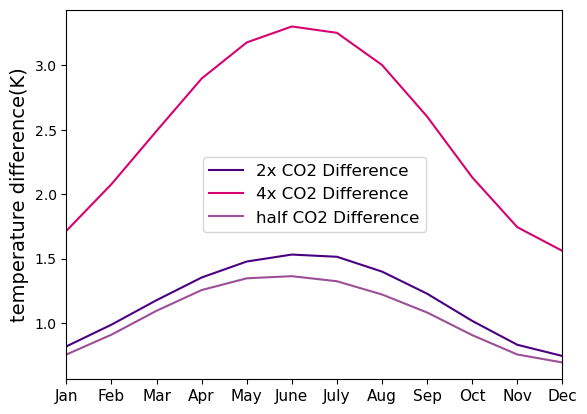

In [13]:
plt.plot(np.arange(12),Ts_equil[:,1]-Ts_equil[:,0],color=colors[0],label="2x CO2 Difference")
plt.plot(np.arange(12),Ts_equil[:,2]-Ts_equil[:,0],color=colors[1],label="4x CO2 Difference")
plt.plot(np.arange(12),Ts_equil[:,0]-Ts_equil[:,3],color=colors[2],label="half CO2 Difference")

plt.xlim(0,11)
plt.xticks(np.arange(12),months,fontsize=11)
plt.ylabel("temperature difference(K)",fontsize=14)
plt.legend(loc="best",fontsize=12)

# plt.savefig("temp difference figures/nyc_diff.png",dpi=300,bbox_inches="tight")
plt.show()